<a href="https://colab.research.google.com/github/alphy1/stds-simulated-annealing/blob/main/Alfiya_Mussabekova_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STDSR. Assignment 3
## Application of Sampling
### Alfiya Mussabekova, DS-01


#### 1. Get the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip '/content/drive/MyDrive/city-master.zip'

Archive:  /content/drive/MyDrive/city-master.zip
ae661bffe572880472249097c9b29c42b09650ea
   creating: city-master/
  inflating: city-master/README.md   
  inflating: city-master/city.csv    
  inflating: city-master/city.csv-metadata.json  


In [31]:
import pandas as pd
df = pd.read_csv('city-master/city.csv')

#### 2. Prepare data, calculate distances

$x_0$ is 30 most populated cities

1. Sort by population in descending order
2. Take 30 first cities
3. Calculate distance between each of them (using geopy)

In [12]:
!pip3 install geopy

In [116]:
import numpy as np
from geopy.distance import geodesic

# sort by population
df.sort_values(by='population', ascending=False, inplace=True)

# take 30 most populated
N = 30
most_populated = df[:N].copy()

# calculate distances between each of them
# ref: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# ref: https://www.geeksforgeeks.org/python-calculate-distance-between-two-places-using-geopy/
geo_coords = (most_populated['geo_lat'].tolist(), most_populated['geo_lon'].tolist())
cities = most_populated['address'].tolist()
distances = np.zeros((N, N))
for i in range(N):
  for j in range(N):
    coord1 = (geo_coords[0][i], geo_coords[1][i])
    coord2 = (geo_coords[0][j], geo_coords[1][j])
    distances[i][j] = geodesic(coord1, coord2).km

#### 3. Helper functions

1. Function to calculate distance in the $path$
2. Function to calculate acceptance ratio
3. Function to calculate proposal distribution

In [117]:
# cost function that calculates distance between all cities in the path
def dist(path):
  cost = 0
  for i in range(1, len(path)):
    cost += distances[path[i-1]][path[i]]
  cost += distances[path[len(path)-1]][0]
  return cost

from math import exp
def accept_ratio(x_new, x_t, T):
  return exp(-(dist(x_new) - dist(x_t)) / T)

def g(x):
  x_new = x.copy()
  samples = np.random.choice(x_new, 2, replace=False)
  x_new[samples[0]], x_new[samples[1]] = x_new[samples[1]], x_new[samples[0]]
  return x_new

#### 4. Simulated Annealing algorithm

1. Initialize $x$, $t$, $T$, and $α$
1. Generate $x'$ by randomly swapping two cities in the path
2. Calculate acceptance ratio $α=\frac{p^*(x')}{p^*(x_t)}$, where: 
$$p^* = e^{-\frac{dist(path)}{T}}$$
$$\frac{p^*(x')}{p^*(x_t)} = \frac{e^{-\frac{dist(x')}{T}}}{e^{-\frac{dist(x_t)}{T}}} = e^{-\frac{dist(x') - dist(x_t)}{T}}$$

3. Accept or reject new state by generating $u ∼ U(0, 1)$. If $u ≤ α$, accept the new state $x_{t+1} = x'$, otherwise propagate the old state
4. Reduce $T$
5. Increment $t$

Wrap everything to one function with changing parameter alpha to track the speed of convergence for three different values of the annealing rate. The function returns path and lists of temperatures and distances

In [138]:
def sa(alpha):
  # intialize x and t
  x = np.random.permutation(N)
  t = 0

  # initialize T
  T = 10000
  
  temps = [T]
  dists = [dist(x)]
  paths = [x]
  while T > 10:
    # generate new x
    x_new = g(x)

    # calculate acceptance ratio
    a = accept_ratio(x_new, x, T)

    # accept or reject new x
    if np.random.uniform() <= a:
      x = x_new

    # update T and t
    T = T * alpha
    t = t + 1
    # log the path, temperature and distance
    paths.append(x)
    dists.append(dist(x))
    temps.append(T)
  return paths, temps, dists

#### 5. Track the speed of convergence for three different values of the annealing rate (try fast cooling, slow cooling, and some middle value). Compare the optimization result.

For fast cooling, I used $α=0.66$, for medium $- α=0.88$, and for slow $-α = 0.99$. 

Plot shows that with slow cooling rate alogorithm minimizes much better than with fast annealing rate. Medium cooling rate is between slow and fast, it takes less steps than for slow rate to come to solution that is better than with fast rate.


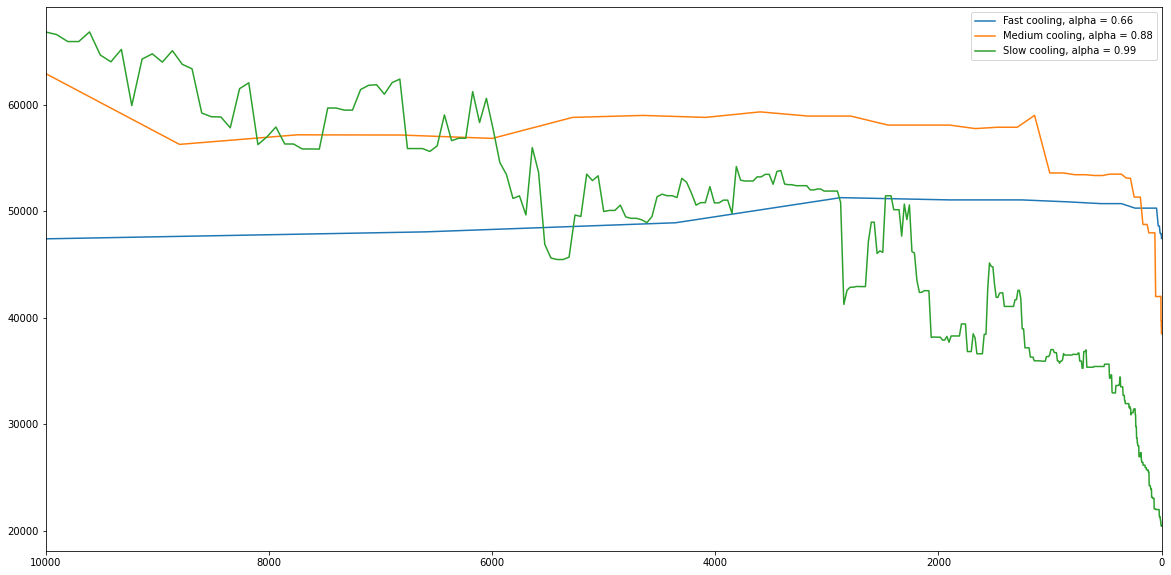

In [151]:
from matplotlib import pyplot as plt

paths_fast, temps_fast, dists_fast = sa(0.66)
paths_medium, temps_medium, dists_medium = sa(0.88)
paths_slow, temps_slow, dists_slow = sa(0.99)

# plot the difference
plt.figure(figsize=(20, 10))
plt.plot(temps_fast, dists_fast, label='Fast cooling, alpha = 0.66')
plt.plot(temps_medium, dists_medium, label='Medium cooling, alpha = 0.88')
plt.plot(temps_slow, dists_slow, label='Slow cooling, alpha = 0.99')
plt.xlim(10000, 0)
plt.legend()
plt.show()

#### 6. Produce a visualization of your optimization process

I will animate optimization process with slow cooling rate

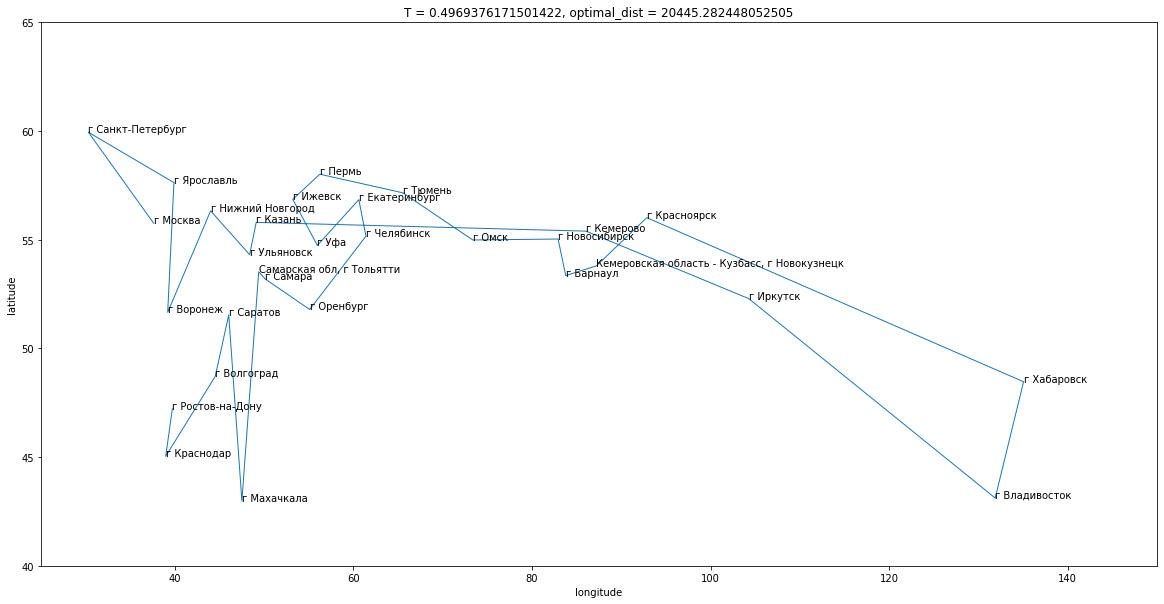

In [152]:
# ref: https://matplotlib.org/stable/api/animation_api.html
from matplotlib.animation import FuncAnimation

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
fig, ax = plt.figure(figsize=(20, 10)), plt.axes()
plt.ylabel('latitude')
plt.xlabel('longitude')
ln, = plt.plot([], [], lw=1)

def init():
    ax.set_xlim(25, 150)
    ax.set_ylim(40, 65)
    ln.set_data([], [])
    return ln,

def update(i):
  xdata = []
  ydata = []
  path = paths_slow[i]
  for p in path:
    ydata.append(geo_coords[0][p])
    xdata.append(geo_coords[1][p])
  # print(xdata)
  ax.title.set_text(f"T = {temps_slow[i]}, optimal_dist = {dists_slow[i]}")
  ln.set_data(xdata, ydata)
  return ln,

ani = FuncAnimation(fig, update, frames=len(paths_slow), init_func=init, blit=True)

for i, city in enumerate(cities):
  ax.annotate(city, (geo_coords[1][i], geo_coords[0][i]))

ani.save('anim.mp4', fps=30)
plt.show()

In [157]:
# ref: https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
from IPython.display import HTML
from base64 import b64encode
mp4 = open('anim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)